In [1]:
# Install required packages
print("📦 Installing packages...")
!pip install -q "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install -q accelerate peft bitsandbytes transformers trl

print("\n✅ Installation complete!")

# Check GPU
import torch

print("\n" + "="*50)
print("🖥️  GPU INFORMATION")
print("="*50)

if torch.cuda.is_available():
    print(f"✅ GPU Available: YES")
    print(f"📛 GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"💾 Total Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"🔢 CUDA Version: {torch.version.cuda}")
else:
    print("❌ No GPU detected!")
    print("⚠️  Please enable GPU: Runtime → Change runtime type → T4 GPU")

print("="*50)

📦 Installing packages...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.9/224.9 kB 17.0 MB/s eta 0:00:00

✅ Installation complete!

🖥️  GPU INFORMATION
✅ GPU Available: YES
📛 GPU Name: Tesla T4
💾 Total Memory: 15.83 GB
🔢 CUDA Version: 12.6


In [2]:
# Mount Google Drive
from google.colab import drive
print("📁 Mounting Google Drive...")
drive.mount('/content/drive')

# Load dataset
from datasets import load_dataset
import os

# Update this path to match where your file is stored
file_path = '/content/drive/MyDrive/llama_finetune/finlit_llama_chat_1000_v2.jsonl'

# Check if file exists
if not os.path.exists(file_path):
    print(f"\n❌ File not found at: {file_path}")
    print("\n📂 Listing files in MyDrive:")
    !ls "/content/drive/MyDrive/"
    print("\n⚠️  Please update the file_path variable above")
else:
    print(f"✅ File found: {file_path}")
    print(f"📊 File size: {os.path.getsize(file_path) / 1024:.2f} KB")

    # Load dataset
    print("\n📥 Loading dataset...")
    dataset = load_dataset('json', data_files=file_path)

    print(f"\n✅ Dataset loaded!")
    print(f"📝 Total samples: {len(dataset['train'])}")
    print(f"\n🔍 Sample entry:")
    print(dataset['train'][0])

📁 Mounting Google Drive...
Mounted at /content/drive
✅ File found: /content/drive/MyDrive/llama_finetune/finlit_llama_chat_1000_v2.jsonl
📊 File size: 516.14 KB

📥 Loading dataset...


Generating train split: 0 examples [00:00, ? examples/s]


✅ Dataset loaded!
📝 Total samples: 1000

🔍 Sample entry:
{'messages': [{'role': 'user', 'content': 'Why is saving important for Malaysian students?'}, {'role': 'assistant', 'content': 'Saving matters because it directly influences whether you feel in control or stressed about money. Saving means keeping part of your income aside instead of spending it now, so you can use it later for goals or emergencies. When you pay attention to it early, you avoid many common mistakes that young adults often regret later.'}]}


In [3]:
# Format dataset for Llama 3.2
def format_llama_prompt(example):
    """Format for Llama 3.2 chat format"""
    messages = example['messages']

    formatted_text = ""
    for msg in messages:
        role = msg['role']
        content = msg['content']

        if role == 'user':
            formatted_text += f"<|start_header_id|>user<|end_header_id|>\n\n{content}<|eot_id|>"
        elif role == 'assistant':
            formatted_text += f"<|start_header_id|>assistant<|end_header_id|>\n\n{content}<|eot_id|>"

    return {'text': formatted_text}

print("Formatting dataset for Llama 3.2...")
dataset = dataset.map(format_llama_prompt)

# Split into train/validation (90/10)
dataset = dataset['train'].train_test_split(test_size=0.1, seed=42)

print(f"\nTrain samples: {len(dataset['train'])}")
print(f"Validation samples: {len(dataset['test'])}")

# Show formatted example
print(f"\nFormatted example:")
print("="*80)
print(dataset['train'][0]['text'][:500])
print("...")
print("="*80)

Formatting dataset for Llama 3.2...


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]


Train samples: 900
Validation samples: 100

Formatted example:
<|start_header_id|>user<|end_header_id|>

What are the main points I should remember about compound interest?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

In summary, compound interest is about three things: understanding your situation, making intentional choices and learning from experience. Compound interest is interest calculated on both the original amount and the interest that has already been added before. If you keep coming back to these ideas, you will slowly build stronger f
...


In [4]:
print(' Upgrading bitsandbytes...')
!pip install -U bitsandbytes
print(' bitsandbytes upgraded!')

 Upgrading bitsandbytes...
 bitsandbytes upgraded!


In [5]:
from unsloth import FastLanguageModel
import torch

max_seq_length = 512
dtype = None  # Auto-detect
load_in_4bit = True

# Load Unsloth model - automatically handles everything!
print("📥 Loading Unsloth Llama 3.2 1B...")
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-1B-Instruct",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

print(" Model loaded!")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
📥 Loading Unsloth Llama 3.2 1B...
==((====))==  Unsloth 2025.12.8: Fast Llama patching. Transformers: 4.57.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.10G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

 Model loaded!


In [6]:
from unsloth import FastLanguageModel

# Unsloth's optimized LoRA
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 16,
    lora_dropout = 0,  # Unsloth optimizes with 0
    bias = "none",
    use_gradient_checkpointing = "unsloth",  # Unsloth's optimization
    random_state = 42,
)

print("\n✅ LoRA applied!")
model.print_trainable_parameters()

Unsloth 2025.12.8 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.



✅ LoRA applied!
trainable params: 11,272,192 || all params: 1,247,086,592 || trainable%: 0.9039


In [7]:
from unsloth import is_bfloat16_supported
from trl import SFTTrainer
from transformers import TrainingArguments

print("⚙️  Setting up Unsloth training...")

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset['train'],
    eval_dataset = dataset['test'],
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,  # Can make training 5x faster for short sequences
    args = TrainingArguments(
        output_dir = "/content/drive/MyDrive/llama_finetune/llama_1b_checkpoints",
        num_train_epochs = 5,
        per_device_train_batch_size = 1,
        per_device_eval_batch_size = 1,
        gradient_accumulation_steps = 4,
        gradient_checkpointing=True,
        warmup_steps = 5,
        max_steps = -1,
        learning_rate = 5e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 10,
        optim = "adafactor",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 42,
        save_strategy = "steps",
        save_steps = 100,
        eval_strategy = "steps",
        eval_steps = 100,
        save_total_limit = 3,
    ),
)

print(" Trainer ready!")
print("\n Training Configuration:")
print(f"   - Epochs: {trainer.args.num_train_epochs}")
print(f"   - Batch size: {trainer.args.per_device_train_batch_size}")
print(f"   - Gradient accumulation: {trainer.args.gradient_accumulation_steps}")
print(f"   - Effective batch size: {trainer.args.per_device_train_batch_size * trainer.args.gradient_accumulation_steps}")
print(f"   - Learning rate: {trainer.args.learning_rate}")

⚙️  Setting up Unsloth training...


Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/900 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/100 [00:00<?, ? examples/s]

 Trainer ready!

 Training Configuration:
   - Epochs: 5
   - Batch size: 1
   - Gradient accumulation: 4
   - Effective batch size: 4
   - Learning rate: 0.0005


In [8]:
import time

print("="*80)
print("🚀 STARTING TRAINING")
print("="*80)
print("\n⏰ Unsloth is 2-5x faster than standard training!")
print("📊 Training progress will be shown below\n")

start_time = time.time()

# Train
trainer_stats = trainer.train()

end_time = time.time()
training_duration = (end_time - start_time) / 60

print("\n" + "="*80)
print("✅ TRAINING COMPLETE!")
print("="*80)
print(f"⏱️  Total training time: {training_duration:.2f} minutes")

# Save model
final_model_path = "/content/drive/MyDrive/llama_finetune/llama_1b_final_final"
print(f"\n💾 Saving final model to: {final_model_path}")

model.save_pretrained(final_model_path)
tokenizer.save_pretrained(final_model_path)

print(" Model saved successfully!")

The model is already on multiple devices. Skipping the move to device specified in `args`.


🚀 STARTING TRAINING

⏰ Unsloth is 2-5x faster than standard training!
📊 Training progress will be shown below



==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 900 | Num Epochs = 5 | Total steps = 1,125
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 11,272,192 of 1,247,086,592 (0.90% trained)
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: muhcuk22 (muhcuk22-universiti-teknologi-mara-official-website) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Detected [huggingface_hub.inference, openai] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


Step,Training Loss,Validation Loss
100,0.206200,0.181235
200,0.098800,0.113072
300,0.084200,0.094198
400,0.073700,0.096175
500,0.069000,0.081092
600,0.070600,0.080683
700,0.071500,0.075389
800,0.069700,0.073630
900,0.072700,0.072075
1000,0.065100,0.072381


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


eval/loss,█▄▂▃▂▂▁▁▁▁▁
eval/runtime,█▆▇▃▁▃▆▂▁▁▂
eval/samples_per_second,▁▂▂▅█▆▃▇██▇
eval/steps_per_second,▁▂▂▅█▆▃▇██▇
train/epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇██
train/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇████
train/grad_norm,█▃▃▂▂▃▂▂▃▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,█████▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,0.07154
eval/runtime,6.4266



✅ TRAINING COMPLETE!
⏱️  Total training time: 21.50 minutes

💾 Saving final model to: /content/drive/MyDrive/llama_finetune/llama_1b_final_final
 Model saved successfully!


📊 TRAINING METRICS VISUALIZATION
✅ Saved: training_dashboard.png


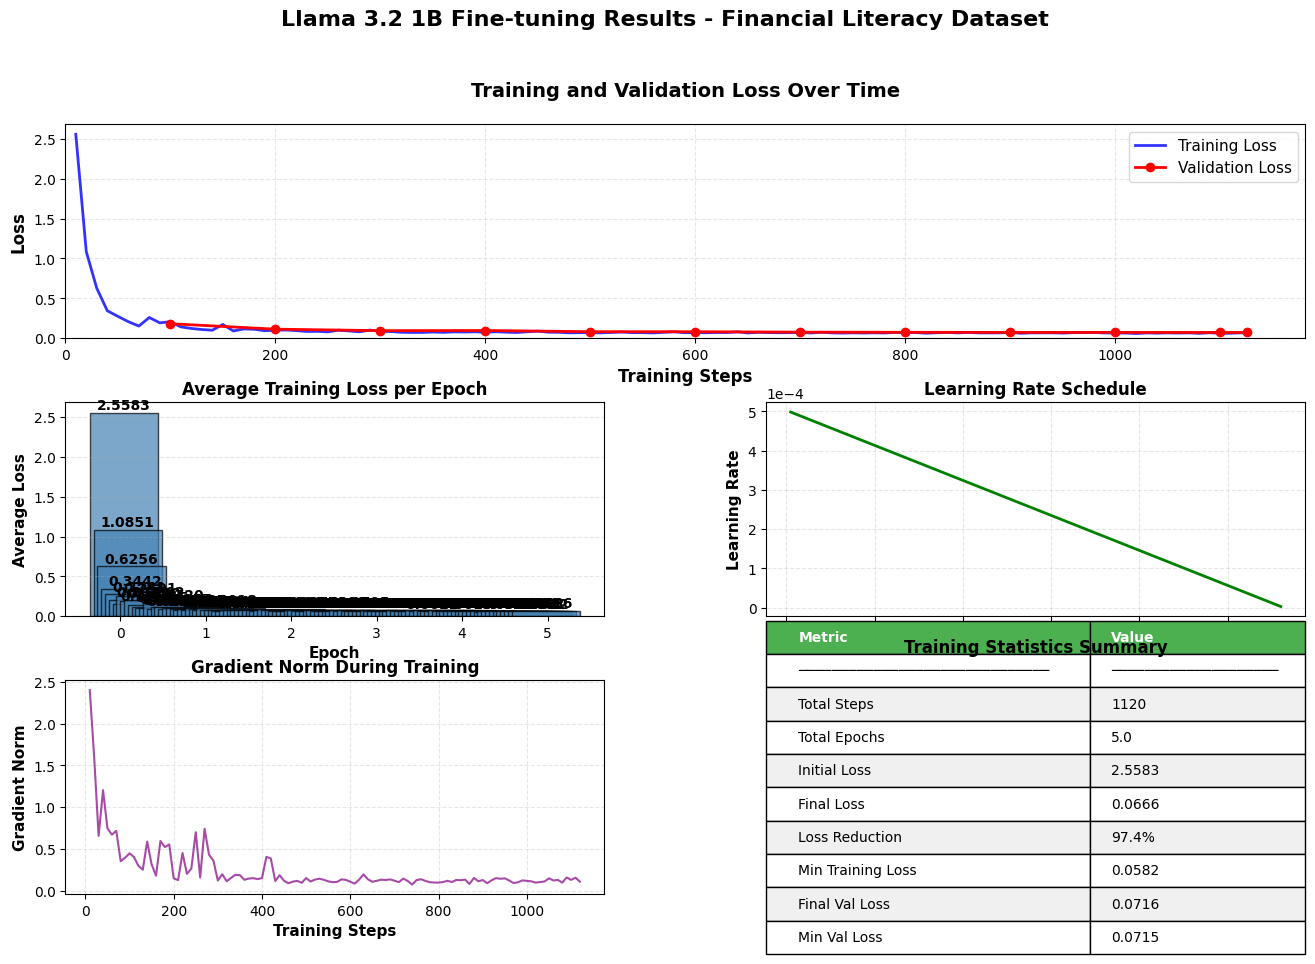

✅ Saved: loss_curve_clean.png


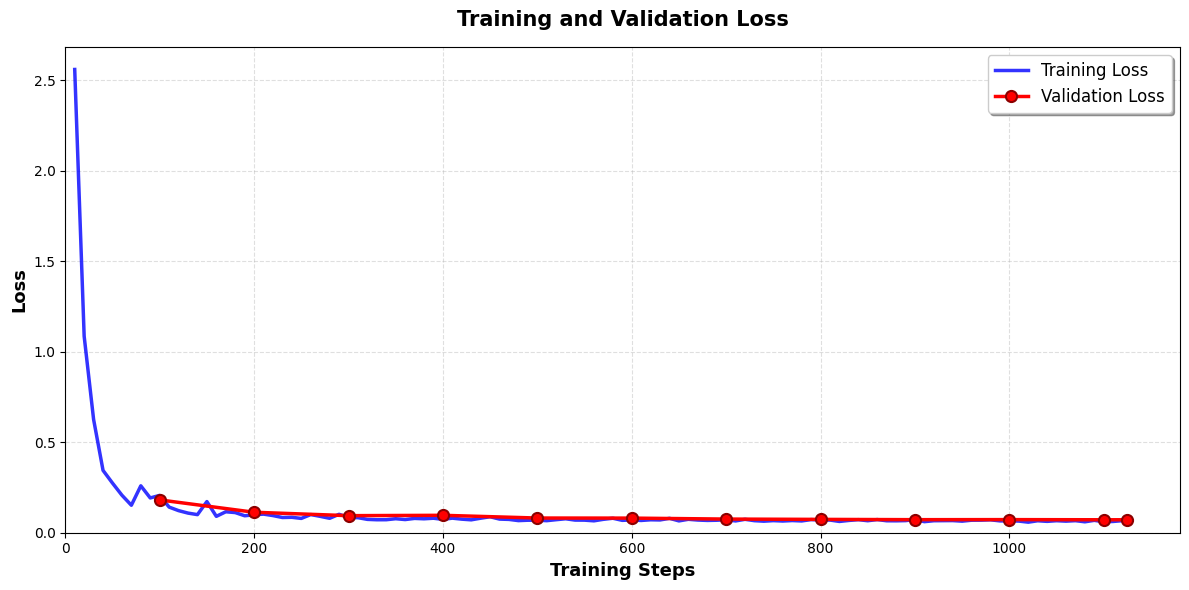

✅ Saved: epoch_loss.png


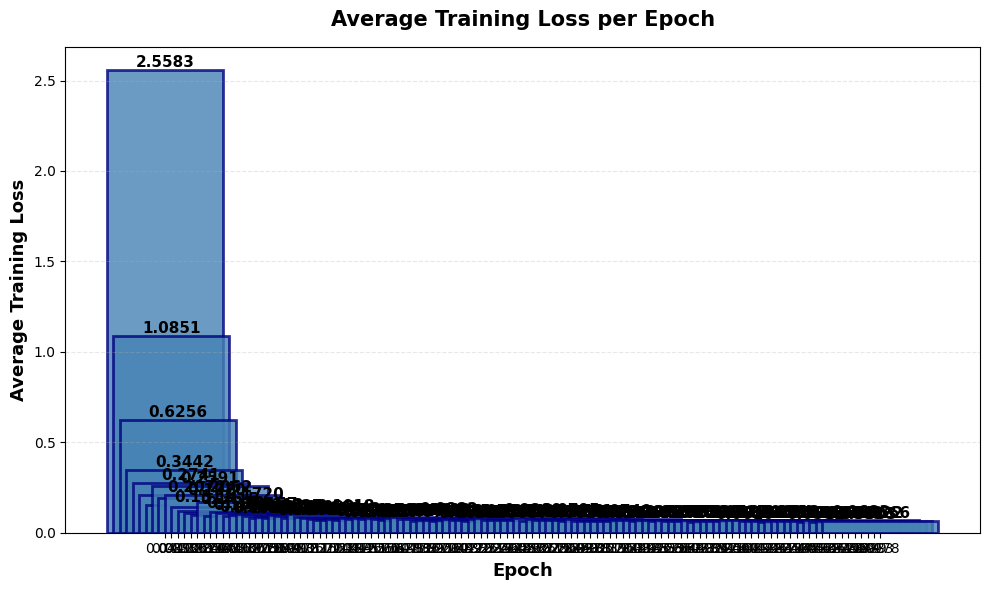


📈 TRAINING SUMMARY
Total Training Steps: 1120
Total Epochs: 4.98
Initial Training Loss: 2.558300
Final Training Loss: 0.066600
Loss Reduction: 97.40%
Minimum Training Loss: 0.058200

Final Validation Loss: 0.071582
Minimum Validation Loss: 0.071545
Overfitting Gap: 0.004982
✅ All visualizations saved to Google Drive!


In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec

# Extract training history from trainer
history = trainer.state.log_history

# Separate training and evaluation logs
train_logs = [log for log in history if 'loss' in log and 'eval_loss' not in log]
eval_logs = [log for log in history if 'eval_loss' in log]

# Create DataFrames
train_df = pd.DataFrame(train_logs)
eval_df = pd.DataFrame(eval_logs)

print("=" * 80)
print("📊 TRAINING METRICS VISUALIZATION")
print("=" * 80)

# ============================================================================
# FIGURE 1: Comprehensive Training Dashboard (For Report)
# ============================================================================
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(3, 2, figure=fig, hspace=0.3, wspace=0.3)

# 1. Training & Validation Loss over Steps
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(train_df['step'], train_df['loss'], 'b-', linewidth=2, label='Training Loss', alpha=0.8)
if not eval_df.empty:
    ax1.plot(eval_df['step'], eval_df['eval_loss'], 'r-', linewidth=2,
             label='Validation Loss', marker='o', markersize=6)
ax1.set_xlabel('Training Steps', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training and Validation Loss Over Time', fontsize=14, fontweight='bold', pad=20)
ax1.legend(fontsize=11, loc='upper right')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_xlim(left=0)
ax1.set_ylim(bottom=0)

# 2. Loss by Epoch
ax2 = fig.add_subplot(gs[1, 0])
epoch_loss = train_df.groupby('epoch')['loss'].mean()
ax2.bar(epoch_loss.index, epoch_loss.values, color='steelblue', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax2.set_ylabel('Average Loss', fontsize=11, fontweight='bold')
ax2.set_title('Average Training Loss per Epoch', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y', linestyle='--')
for i, v in enumerate(epoch_loss.values):
    ax2.text(epoch_loss.index[i], v + 0.005, f'{v:.4f}',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

# 3. Learning Rate Schedule
ax3 = fig.add_subplot(gs[1, 1])
if 'learning_rate' in train_df.columns:
    ax3.plot(train_df['step'], train_df['learning_rate'], 'g-', linewidth=2)
    ax3.set_xlabel('Training Steps', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Learning Rate', fontsize=11, fontweight='bold')
    ax3.set_title('Learning Rate Schedule', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, linestyle='--')
    ax3.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# 4. Gradient Norm (if available)
ax4 = fig.add_subplot(gs[2, 0])
if 'grad_norm' in train_df.columns:
    ax4.plot(train_df['step'], train_df['grad_norm'], 'purple', linewidth=1.5, alpha=0.7)
    ax4.set_xlabel('Training Steps', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Gradient Norm', fontsize=11, fontweight='bold')
    ax4.set_title('Gradient Norm During Training', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3, linestyle='--')

# 5. Training Statistics Table
ax5 = fig.add_subplot(gs[2, 1])
ax5.axis('off')

# Calculate statistics
stats_data = [
    ['Metric', 'Value'],
    ['─' * 30, '─' * 20],
    ['Total Steps', f"{train_df['step'].max():.0f}"],
    ['Total Epochs', f"{train_df['epoch'].max():.1f}"],
    ['Initial Loss', f"{train_df['loss'].iloc[0]:.4f}"],
    ['Final Loss', f"{train_df['loss'].iloc[-1]:.4f}"],
    ['Loss Reduction', f"{(1 - train_df['loss'].iloc[-1]/train_df['loss'].iloc[0])*100:.1f}%"],
    ['Min Training Loss', f"{train_df['loss'].min():.4f}"],
]

if not eval_df.empty:
    stats_data.extend([
        ['Final Val Loss', f"{eval_df['eval_loss'].iloc[-1]:.4f}"],
        ['Min Val Loss', f"{eval_df['eval_loss'].min():.4f}"],
    ])

table = ax5.table(cellText=stats_data, cellLoc='left', loc='center',
                  colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style header row
for i in range(2):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style data rows
for i in range(2, len(stats_data)):
    for j in range(2):
        table[(i, j)].set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')

ax5.set_title('Training Statistics Summary', fontsize=12, fontweight='bold', pad=20)

plt.suptitle('Llama 3.2 1B Fine-tuning Results - Financial Literacy Dataset',
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig('/content/drive/MyDrive/llama_finetune/training_dashboard.png',
            dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Saved: training_dashboard.png")
plt.show()

# ============================================================================
# FIGURE 2: Simple Loss Curve (Clean for Report)
# ============================================================================
plt.figure(figsize=(12, 6))
plt.plot(train_df['step'], train_df['loss'], 'b-', linewidth=2.5,
         label='Training Loss', alpha=0.8)
if not eval_df.empty:
    plt.plot(eval_df['step'], eval_df['eval_loss'], 'r-', linewidth=2.5,
             label='Validation Loss', marker='o', markersize=8, markerfacecolor='red',
             markeredgecolor='darkred', markeredgewidth=1.5)

plt.xlabel('Training Steps', fontsize=13, fontweight='bold')
plt.ylabel('Loss', fontsize=13, fontweight='bold')
plt.title('Training and Validation Loss', fontsize=15, fontweight='bold', pad=15)
plt.legend(fontsize=12, loc='upper right', frameon=True, shadow=True)
plt.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)
plt.xlim(left=0)
plt.ylim(bottom=0)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/llama_finetune/loss_curve_clean.png',
            dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Saved: loss_curve_clean.png")
plt.show()

# ============================================================================
# FIGURE 3: Loss by Epoch (Bar Chart for Report)
# ============================================================================
plt.figure(figsize=(10, 6))
epoch_loss = train_df.groupby('epoch')['loss'].mean()
bars = plt.bar(epoch_loss.index, epoch_loss.values, color='steelblue',
               alpha=0.8, edgecolor='navy', linewidth=2)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xlabel('Epoch', fontsize=13, fontweight='bold')
plt.ylabel('Average Training Loss', fontsize=13, fontweight='bold')
plt.title('Average Training Loss per Epoch', fontsize=15, fontweight='bold', pad=15)
plt.grid(True, alpha=0.3, axis='y', linestyle='--')
plt.xticks(epoch_loss.index)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/llama_finetune/epoch_loss.png',
            dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Saved: epoch_loss.png")
plt.show()

# ============================================================================
# Print Summary Statistics
# ============================================================================
print("\n" + "=" * 80)
print("📈 TRAINING SUMMARY")
print("=" * 80)
print(f"Total Training Steps: {train_df['step'].max():.0f}")
print(f"Total Epochs: {train_df['epoch'].max():.2f}")
print(f"Initial Training Loss: {train_df['loss'].iloc[0]:.6f}")
print(f"Final Training Loss: {train_df['loss'].iloc[-1]:.6f}")
print(f"Loss Reduction: {(1 - train_df['loss'].iloc[-1]/train_df['loss'].iloc[0])*100:.2f}%")
print(f"Minimum Training Loss: {train_df['loss'].min():.6f}")

if not eval_df.empty:
    print(f"\nFinal Validation Loss: {eval_df['eval_loss'].iloc[-1]:.6f}")
    print(f"Minimum Validation Loss: {eval_df['eval_loss'].min():.6f}")
    print(f"Overfitting Gap: {abs(train_df['loss'].iloc[-1] - eval_df['eval_loss'].iloc[-1]):.6f}")

print("=" * 80)
print("✅ All visualizations saved to Google Drive!")
print("=" * 80)

In [9]:
print("="*80)
print("📊 EVALUATING MODEL")
print("="*80)

# Disable W&B logging for evaluation
import os
os.environ['WANDB_MODE'] = 'disabled'

# Remove W&B callback to avoid logging errors
from transformers.integrations import WandbCallback
trainer.remove_callback(WandbCallback)

# Run evaluation
eval_results = trainer.evaluate()

print("\n📈 Evaluation Results:")
print("-" * 40)
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")

print("\n" + "="*80)

📊 EVALUATING MODEL



📈 Evaluation Results:
----------------------------------------
eval_loss: 0.0716
eval_runtime: 5.8701
eval_samples_per_second: 17.0350
eval_steps_per_second: 17.0350
epoch: 5.0000



In [10]:
print("="*80)
print("🧪 TESTING FINE-TUNED MODEL")
print("="*80)

# Enable fast inference
FastLanguageModel.for_inference(model)

def generate_response(prompt, max_length=256):
    """Generate response using Unsloth"""
    messages = [{"role": "user", "content": prompt}]

    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize = True,
        add_generation_prompt = True,
        return_tensors = "pt",
    ).to("cuda")

    outputs = model.generate(
        input_ids = inputs,
        max_new_tokens = max_length,
        temperature = 0.7,
        top_p = 0.9,
        do_sample = True,
    )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract assistant response
    if "assistant" in response:
        response = response.split("assistant")[-1].strip()

    return response

# Test questions
test_prompts = [
    "What is compound interest?",
    "How should I start investing as a beginner?",
    "Explain the difference between stocks and bonds.",
    "What is an emergency fund and why do I need one?",
]

print("\n🔍 Testing with sample questions:\n")

for i, prompt in enumerate(test_prompts, 1):
    print(f"\n{'='*80}")
    print(f"Question {i}: {prompt}")
    print("-" * 80)

    response = generate_response(prompt)
    print(f"Response: {response}")

print("\n" + "="*80)
print("✅ Testing complete!")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


🧪 TESTING FINE-TUNED MODEL

🔍 Testing with sample questions:


Question 1: What is compound interest?
--------------------------------------------------------------------------------
Response: Compound interest is interest calculated on both the original amount and the interest that has already been added before. In simple terms, it gives you a clearer picture of your money so you can make calmer, smarter decisions.

Question 2: How should I start investing as a beginner?
--------------------------------------------------------------------------------
Response: It's normal to feel anxious about money as a student, but investing can give you a sense of structure. Investing is putting your money into things that will give you returns over time, rather than keeping it safe and watching it grow at 0% interest. Start small, be consistent, and remember that every good decision you make now reduces pressure on your future self.

Question 3: Explain the difference between stocks and bonds.
---

In [ ]:
# ============================================================================
# EXPORT FINE-TUNED MODEL TO GGUF FOR OLLAMA
# ============================================================================
# Add this cell to your Colab notebook AFTER training is complete

print("="*80)
print("🔄 EXPORTING MODEL TO GGUF FORMAT FOR OLLAMA")
print("="*80)

from unsloth import FastLanguageModel
import os

# Path to your fine-tuned model
model_path = "/content/drive/MyDrive/llama_finetune/llama_1b_final"

print(f"\n📂 Loading model from: {model_path}")

# Load your fine-tuned model
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_path,
    max_seq_length = 512,
    dtype = None,
    load_in_4bit = True,
)

print("✅ Model loaded successfully!")

# ============================================================================
# CHOOSE YOUR QUANTIZATION METHOD
# ============================================================================
# Uncomment ONE of the options below based on your needs:

# OPTION 1: BEST QUALITY (Recommended for production)
# File size: ~2GB, Best accuracy, Medium speed
quantization_method = "f16"

# OPTION 2: BALANCED (Good for most cases)
# File size: ~1GB, Good accuracy, Fast speed
# quantization_method = "q8_0"

# OPTION 3: FAST & SMALL (For testing/quick demos)
# File size: ~600MB, Decent accuracy, Very fast
# quantization_method = "q4_k_m"

# OPTION 4: SMALLEST (For limited resources)
# File size: ~500MB, Lower accuracy, Fastest
# quantization_method = "q4_0"

print(f"\n⚙️ Using quantization: {quantization_method}")
print(f"💡 This determines file size and quality")

# ============================================================================
# EXPORT TO GGUF
# ============================================================================

output_name = "finlit-llama-1b"
save_directory = "/content/drive/MyDrive/llama_finetune/gguf_export"

print(f"\n📦 Exporting to GGUF format...")
print(f"📁 Save location: {save_directory}")

# Create directory if it doesn't exist
os.makedirs(save_directory, exist_ok=True)

# Export the model
model.save_pretrained_gguf(
    save_directory,  # First parameter is save_directory
    tokenizer,
    quantization_method = quantization_method
)

print("\n" + "="*80)
print("✅ EXPORT COMPLETE!")
print("="*80)

# Show the exported file path
gguf_file = f"{output_name}-{quantization_method}.gguf"
full_path = os.path.join(save_directory, gguf_file)

print(f"\n📄 Exported file: {gguf_file}")
print(f"📂 Full path: {full_path}")

# Check file size
if os.path.exists(full_path):
    file_size_mb = os.path.getsize(full_path) / (1024 * 1024)
    print(f"💾 File size: {file_size_mb:.2f} MB")
else:
    print("⚠️ Warning: File not found at expected location")

print("\n" + "="*80)
print("📋 NEXT STEPS:")
print("="*80)
print("1. Download the GGUF file from your Google Drive:")
print(f"   {save_directory}/{gguf_file}")
print("\n2. Create a Modelfile on your computer with this content:")
print(f"""
-------------------
FROM ./{gguf_file}

PARAMETER temperature 0.7
PARAMETER top_p 0.9
PARAMETER num_predict 256

SYSTEM \"\"\"You are a financial literacy assistant for Malaysian youth.
You provide clear, practical advice about personal finance, savings,
budgeting, and investments based on Malaysian context (EPF/KWSP).
Keep responses concise and easy to understand.\"\"\"
-------------------
""")
print("\n3. Import to Ollama:")
print("   ollama create finlit-llama -f Modelfile")
print("\n4. Update your s_app.py:")
print('   LLM_MODEL = "finlit-llama"')
print("\n5. Run your app:")
print("   streamlit run s_app.py")
print("="*80)

# ============================================================================
# OPTIONAL: DOWNLOAD DIRECTLY FROM COLAB
# ============================================================================
# Uncomment the lines below to download directly instead of saving to Drive

# from google.colab import files
# print("\n📥 Downloading file to your computer...")
# files.download(full_path)
# print("✅ Download started! Check your browser's download folder.")

print("\n🎉 All done! Your model is ready for Ollama!")

🔄 EXPORTING MODEL TO GGUF FORMAT FOR OLLAMA
🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!

📂 Loading model from: /content/drive/MyDrive/llama_finetune/llama_1b_final
==((====))==  Unsloth 2025.12.8: Fast Llama patching. Transformers: 4.57.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2025.12.8 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


✅ Model loaded successfully!

⚙️ Using quantization: f16
💡 This determines file size and quality

📦 Exporting to GGUF format...
📁 Save location: /content/drive/MyDrive/llama_finetune/gguf_export
Unsloth: Merging model weights to 16-bit format...
Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Cache check failed: model.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Preparing safetensor model files: 100%|██████████| 1/1 [00:00<00:00, 735.71it/s]


Note: tokenizer.model not found (this is OK for non-SentencePiece models)


Unsloth: Merging weights into 16bit: 100%|██████████| 1/1 [01:02<00:00, 62.19s/it]


Unsloth: Merge process complete. Saved to `/content/drive/MyDrive/llama_finetune/gguf_export`
Unsloth: Converting to GGUF format...
==((====))==  Unsloth: Conversion from HF to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF f16 might take 3 minutes.
\        /    [2] Converting GGUF f16 to ['f16'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: llama.cpp folder exists but binaries not found - will rebuild
Unsloth: Updating system package directories
Unsloth: All required system packages already installed!
Unsloth: Install llama.cpp and building - please wait 1 to 3 minutes
Unsloth: Install GGUF and other packages
